# Import the Necessary Libraries

In [1]:
# Data and Plotting
import pandas as pd
import numpy as np
import plotly.express as px
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

# Data encoding and Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Dimensionality Reduction and Clustering Algorithms
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.utils.class_weight import compute_sample_weight

# Data spliting and Cross Validation and Performance Metrics
from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import recall_score, f1_score, balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import  make_scorer,  precision_score, accuracy_score 

# models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier as FNN

from collections import defaultdict as dd
from sklearn.utils import resample

%matplotlib notebook

# Load the Dataset

In [2]:
data = pd.read_csv("Thyroid_Diff.csv")

X = data.drop("Recurred", axis=1)
y = data["Recurred"]
y = y.map({"No":0,"Yes":1})

X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=.75, 
                                       random_state=321
                                      )
y_train.value_counts()

Recurred
0    210
1     77
Name: count, dtype: int64

# Define the Data Preprocessing Encoders

In [3]:
# Define preprocessor
num_features = list(X.columns[:1])
cat_features = list(X.columns[1:])

# Define the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ("scaler", MinMaxScaler())
])

# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

# Define your ColumnTransformer (preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder="passthrough",
)

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Define the Bootstrapping Function to Calculate 95 % CI for AUC, and the Parameters for Plotting the ROC

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def bootstrap_roc_curve(y_true, y_score, n_iterations=1000, alpha=0.05, random_state=42):
    
    rng = np.random.RandomState(random_state)
    n_samples = len(y_true)
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    for _ in range(n_iterations):
        indices = rng.choice(range(n_samples), size=n_samples, replace=True)
        y_true_bs = np.array(y_true)[indices]
        y_score_bs = np.array(y_score)[indices]

        fpr, tpr, _ = roc_curve(y_true_bs, y_score_bs)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # Ensure TPR starts at 0
        tprs.append(interp_tpr)

        auc = roc_auc_score(y_true_bs, y_score_bs)
        aucs.append(auc)

    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr = tprs.std(axis=0)

    auc_mean = np.mean(aucs)
    ci_lower = np.percentile(aucs, 100 * (alpha / 2))
    ci_upper = np.percentile(aucs, 100 * (1 - alpha / 2))

    return {
        'mean_fpr': mean_fpr,
        'mean_tpr': mean_tpr,
        'std_tpr': std_tpr,
        'auc_mean': auc_mean,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Define the Models

In [5]:
# PCA
pca = PCA(n_components=5)

# Define models with best parameters
models_pca = {
    "RF": RFC(criterion='entropy', max_depth=None, max_features='log2', min_samples_leaf=4, min_samples_split=6, 
              n_estimators=403),
    "GB": GBC(criterion='friedman_mse', learning_rate=0.35, loss='exponential', max_depth=6, n_estimators=150, tol=1e-12),
    "SVM": SVC(probability=True, C=0.1, kernel='sigmoid', tol=0.001),
    "LR": LR(C=0.36, penalty='l1', solver='liblinear'),
    "KNN": KNN(n_neighbors=17, p=2, weights='distance'),
    "FNN": FNN(activation='relu', alpha=0.5, early_stopping=True, hidden_layer_sizes=(300,), learning_rate='adaptive', 
               max_iter=10000, solver='lbfgs', tol=1e-05),
}


# tSVD
tsvd = TruncatedSVD(n_components=5)

models_tsvd = {
    "RF": RFC(criterion='entropy', max_depth=None, max_features='log2', 
              min_samples_leaf=3, min_samples_split=6, n_estimators=400),
    "GB": GBC(criterion='squared_error', learning_rate=0.3, loss='log_loss', 
              max_depth=4, n_estimators=125, tol=1e-10),
    "SVM": SVC(probability=True, C=0.25, kernel='sigmoid', tol=0.01),
    "LR": LR(C=0.1, max_iter=5000, penalty='l2', solver='liblinear', tol=0.001),
    "KNN": KNN(n_neighbors=18, p=4, weights='distance'),
    "FNN": FNN(activation='identity', alpha=1.0, early_stopping=True, hidden_layer_sizes=(125, 155), 
               learning_rate='constant', max_iter=15000, solver='adam', tol=0.001),
}

# Plotting ROC-AUC Curves for PCA and tSVD Classification Pipelines

<IPython.core.display.Javascript object>


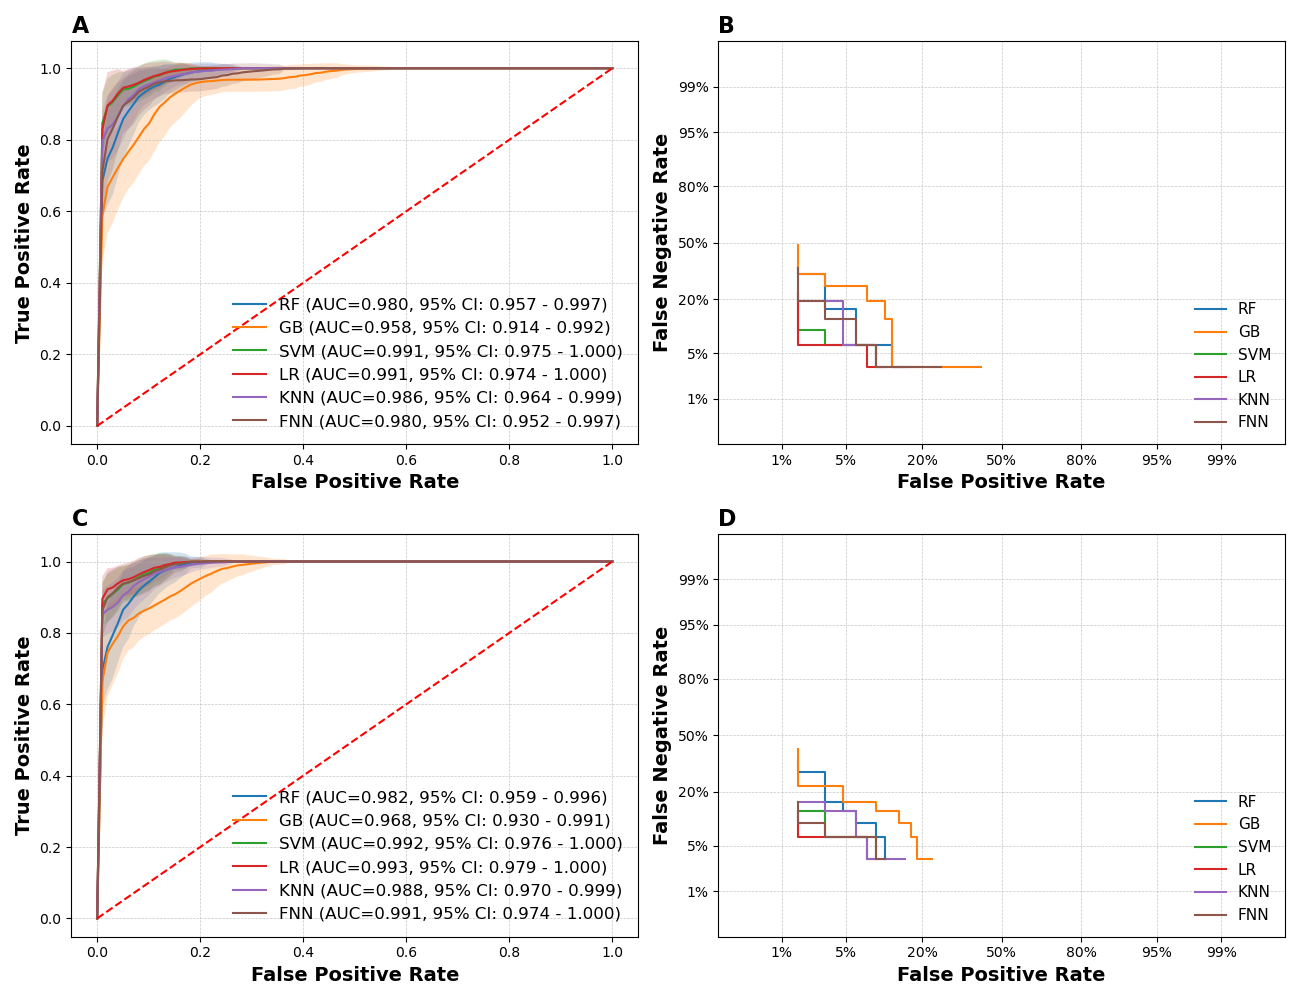

PCA-RF — mean AUC: 0.980, 95% CI: [0.957 - 0.997]
PCA-GB — mean AUC: 0.958, 95% CI: [0.914 - 0.992]
PCA-SVM — mean AUC: 0.991, 95% CI: [0.975 - 1.000]
PCA-LR — mean AUC: 0.991, 95% CI: [0.974 - 1.000]
PCA-KNN — mean AUC: 0.986, 95% CI: [0.964 - 0.999]
PCA-FNN — mean AUC: 0.980, 95% CI: [0.952 - 0.997]
t-SVD-RF — mean AUC: 0.982, 95% CI: [0.959 - 0.996]
t-SVD-GB — mean AUC: 0.968, 95% CI: [0.930 - 0.991]
t-SVD-SVM — mean AUC: 0.992, 95% CI: [0.976 - 1.000]
t-SVD-LR — mean AUC: 0.993, 95% CI: [0.979 - 1.000]
t-SVD-KNN — mean AUC: 0.988, 95% CI: [0.970 - 0.999]
t-SVD-FNN — mean AUC: 0.991, 95% CI: [0.974 - 1.000]


In [6]:
def create_pipeline(preprocessor, reducer, model):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("reducer", reducer),
        ("clf", model),
    ])

def evaluate_and_plot(ax_roc, ax_det, pipeline, X_train, X_test, y_train, y_test, name, label_prefix):
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    roc_stats = bootstrap_roc_curve(y_test, y_proba, n_iterations=200)
    print(f"{label_prefix}-{name} — mean AUC: {roc_stats['auc_mean']:.3f}, 95% CI: [{roc_stats['ci_lower']:.3f} - {roc_stats['ci_upper']:.3f}]")
    
    ax_roc.plot(roc_stats['mean_fpr'], roc_stats['mean_tpr'],
                label=f"{name} (AUC={roc_stats['auc_mean']:.3f}, 95% CI: {roc_stats['ci_lower']:.3f} - {roc_stats['ci_upper']:.3f})")
    ax_roc.fill_between(roc_stats['mean_fpr'],
                        roc_stats['mean_tpr'] - roc_stats['std_tpr'],
                        roc_stats['mean_tpr'] + roc_stats['std_tpr'],
                        alpha=0.2)
    
    # DET Curve
    DetCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax_det, name=name
    )

# Define models and reducers
pca = PCA(n_components=5)
tsvd = TruncatedSVD(n_components=5)

reducers = {"PCA": pca, "t-SVD": tsvd}
model_sets = {"PCA": models_pca, "t-SVD": models_tsvd}

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
ax_roc_pca, ax_det_pca, ax_roc_tsvd, ax_det_tsvd = axes.flatten()
axes_map = {
    "PCA": (ax_roc_pca, ax_det_pca),
    "t-SVD": (ax_roc_tsvd, ax_det_tsvd)
}

# Iterate through reducers and their models
for label_prefix, reducer in reducers.items():
    models = model_sets[label_prefix]
    ax_roc, ax_det = axes_map[label_prefix]

    for name, model in models.items():
        pipeline = create_pipeline(preprocessor, reducer, model)
        evaluate_and_plot(ax_roc, ax_det, pipeline, X_train, X_test, y_train, y_test, name, label_prefix)

# Formatting function
def format_axes(ax_roc, ax_det, roc_title, det_title):
    ax_roc.plot([0, 1], [0, 1], 'r--')
    ax_roc.set_xlabel('False Positive Rate', fontsize=14, fontweight="bold")
    ax_roc.set_ylabel('True Positive Rate', fontsize=14, fontweight="bold")
    ax_roc.set_title(roc_title, fontsize=16, loc="left", fontweight="bold")
    ax_roc.legend(loc='lower right', fontsize=12, frameon=False)
    ax_roc.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    ax_det.set_xlabel('False Positive Rate', fontsize=14, fontweight="bold")
    ax_det.set_ylabel('False Negative Rate', fontsize=14, fontweight="bold")
    ax_det.set_title(det_title, loc="left", fontsize=16, fontweight="bold")
    ax_det.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax_det.legend(loc='lower right', fontsize=11, frameon=False)

# Apply formatting
format_axes(ax_roc_pca, ax_det_pca, "A", "B")
format_axes(ax_roc_tsvd, ax_det_tsvd, "C", "D")

plt.tight_layout()
plt.savefig("../results/ROC_and_DET_Curves_for_PCA_and_tSVD_on_Training_Set.png", dpi=1200)
plt.show()